#### Question 1

a. The last datapoint was released on 26/09/2025.

b. The month being measured was August, 2025.

c. The series is now indexing the latest release as 30/11/2025.

d. The changes in the dates change forecasts by creating lookahead bias. If a forecaster uses data that was not available at the indexed time to train a model, the model will have an unfair advantage and will likely not perform as well in the future.

#### Question 2

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import morethemes as mt
mt.set_theme('economist')
import warnings
warnings.filterwarnings('ignore')

In [140]:
df = pd.read_csv('data.csv')
df.set_index('Date', inplace=True)

##### Part a. 

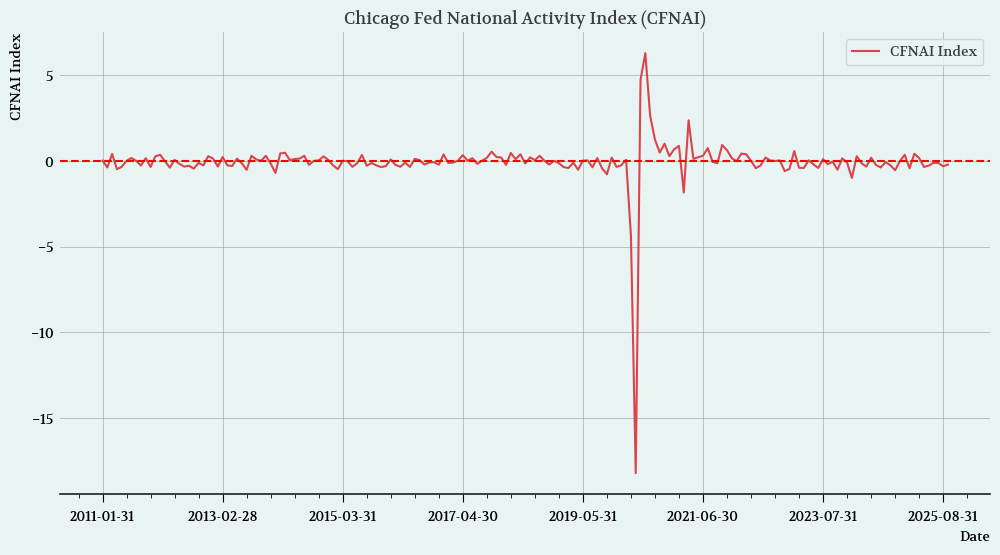

In [141]:
#GitHub Copilot suggested the labels and title
df.plot(y='CFNAI Index', figsize=(12,6))
plt.title('Chicago Fed National Activity Index (CFNAI)')
plt.xlabel('Date')
plt.ylabel('CFNAI Index')
plt.axhline(0, color='red', linestyle='--')
plt.show()

##### Part b. 
It makes sense to use the CFNAI as a proxy for the output gap because it indicates whether economic activity is above or below its long-run trend. Since potential output is unobservable in real time, CFNAI provides a way to capture deviations from trend. Negative values indicate a negative output gap and positive values indicate a positive one.

#### Question 3

##### Part c.

In [142]:
df['Inflation Gap'] = df['PCE CYOY Index'] - 2.0

##### Part b. 

In [ ]:
window = 36

y = df["fedfunds"].astype(float)

X = df[["CFNAI Index", "Inflation Gap"]].astype(float)
X = sm.add_constant(X)

pred = pd.Series(np.nan, index=df.index, dtype=float)

for t in range(window, len(df)):
    y_train = y.iloc[t - window : t]
    X_train = X.iloc[t - window : t]
    train = pd.concat([y_train, X_train], axis=1).dropna()
    model = sm.OLS(train.iloc[:, 0], train.iloc[:, 1:]).fit()
    pred.iloc[t] = model.predict(X.iloc[t : t + 1])[0]

df["Fed Funds"] = pred

##### Part c. 

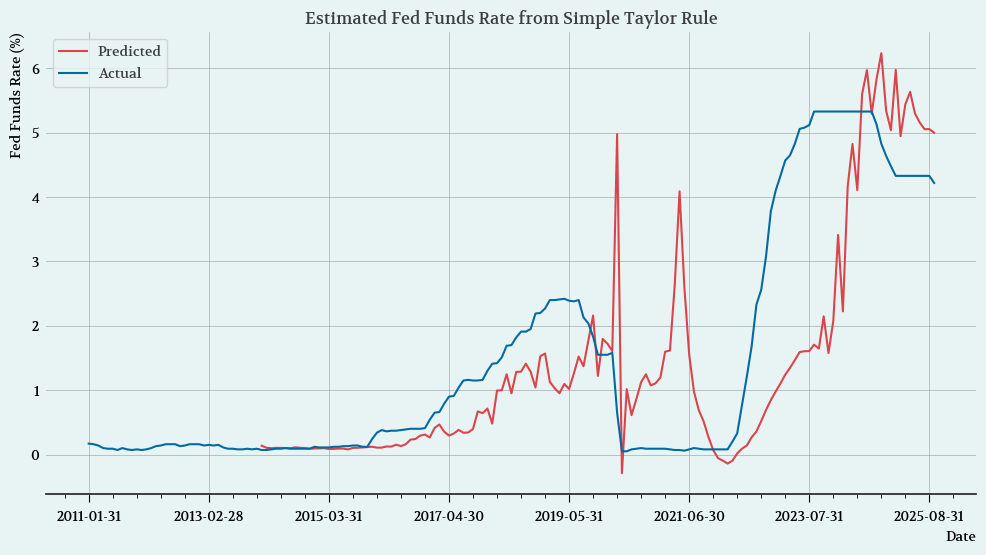

In [151]:
#GitHub Copilot suggested labels and title
df.plot(y=['Fed Funds', 'fedfunds'], figsize=(12,6))
plt.title('Estimated Fed Funds Rate from Simple Taylor Rule')
plt.xlabel('Date')
plt.ylabel('Fed Funds Rate (%)')
plt.legend(['Predicted', 'Actual'])
plt.show()

#### Question 4
##### Part a.

In [145]:
# Trading strategy: long SHY if predicted Fed Funds > observed, short otherwise
predicted_col = 'Fed Funds'
observed_col = 'fedfunds'
price_col = 'SHY US Equity'

signal = np.where(df[predicted_col] > df[observed_col], 1, -1)

# One-period holding: apply signal at t to return from t-1 to t
shy_ret = df[price_col].pct_change()
strategy_ret = pd.Series(signal, index=df.index).shift(1) * shy_ret

strategy = pd.DataFrame({
    'signal': signal,
    'shy_ret': shy_ret,
    'strategy_ret': strategy_ret
}, index=df.index)

strategy.head(10)

,signal,shy_ret,strategy_ret
Date,,,
2011-01-31,-1,NaN,NaN
2011-02-28,-1,-0.002022,0.002022
2011-03-31,-1,-0.002026,0.002026
2011-04-30,-1,0.004537,-0.004537
2011-05-31,-1,0.002853,-0.002853
2011-06-30,-1,-0.000830,0.000830
2011-07-31,-1,0.002135,-0.002135
2011-08-31,-1,0.002723,-0.002723
2011-09-30,-1,-0.001653,0.001653


#### Part c.

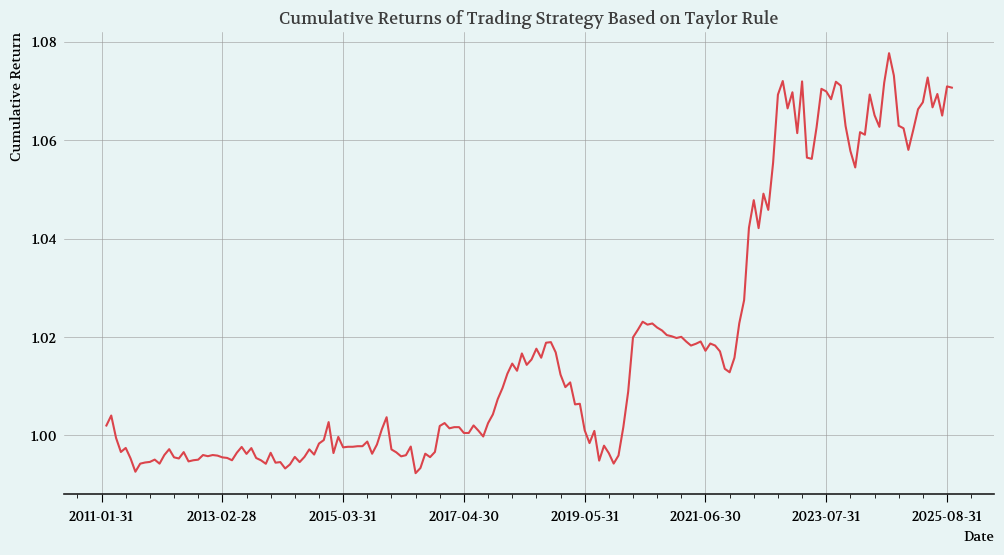

In [146]:
#GitHub Copilot suggested labels and title
(strategy['strategy_ret'] + 1).cumprod().plot(figsize=(12,6))
plt.title('Cumulative Returns of Trading Strategy Based on Taylor Rule')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

##### Part c.

In [147]:
#GitHub Copilot was used for Dataframe formatting
period_return = (strategy['strategy_ret'] + 1).prod() - 1
start_date = pd.to_datetime(strategy.index[0])
end_date = pd.to_datetime(strategy.index[-1])
years = (end_date - start_date).days / 365.25
annualized_return = (1 + period_return) ** (1 / years) - 1

annualized_df = pd.DataFrame({
    'Metric': ['Annualized Return'],
    'Value': [f'{annualized_return:.2%}']
})
annualized_df.style.hide(axis='index')

Metric,Value
Annualized Return,0.47%


##### Part d. 

In [148]:
#GitHub Copilot was used for Dataframe formatting
skewness_value = strategy['strategy_ret'].skew()

skewness_df = pd.DataFrame({
    'Metric': ['Skew'],
    'Value': [skewness_value]
})
skewness_df.style.hide(axis='index')

Metric,Value
Skew,0.291997


The Taylor-rule predictions overestimate the federal funds rate in the post-COVID period because the rolling window includes the rapid inflation surge and aggressive tightening cycle. This leads the model to predict a more aggressive policy reaction than the Fed did in reality.